In [19]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn import linear_model
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import networkx as nx
from random import shuffle
from networkx.algorithms import bipartite

DATA_FOLDER = "/Users/karunya/Documents/EPFL/ADA/ADA_Group_Tota_Pasari_Prelot/04 - Applied ML/"

In [2]:
# import csv data into a dataframe
file = glob.glob(DATA_FOLDER + "lalonde.csv")
df = pd.read_csv(file[0])
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## Question 1: Propensity score matching

### 1. A naive analysis
#### Compare the distribution of the outcome variable (re78) between the two groups (if subject participated in job training or not), using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

#### What might a naive "researcher" conclude from this superficial analysis?

Let's try to look at the dataset

In [3]:
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


We observe below that there is no null values

In [4]:
df.isnull().any()

id          False
treat       False
age         False
educ        False
black       False
hispan      False
married     False
nodegree    False
re74        False
re75        False
re78        False
dtype: bool

Let's look at the distribution of the variable of interest


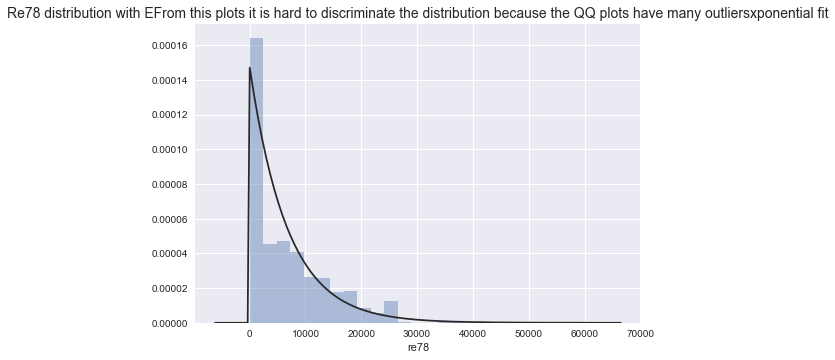

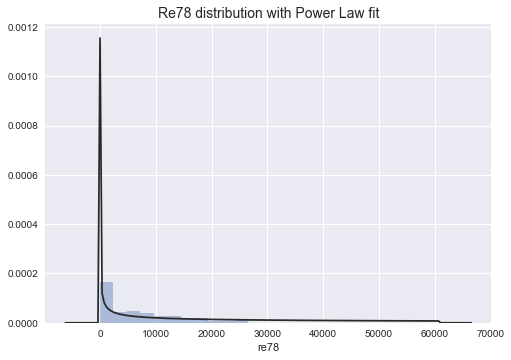

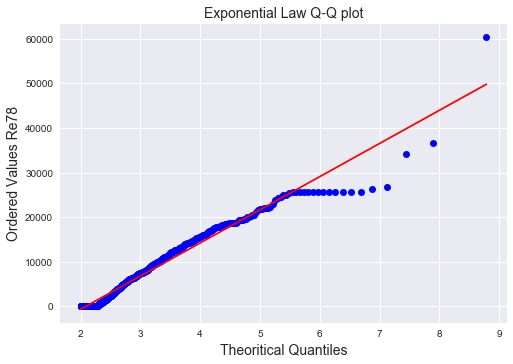

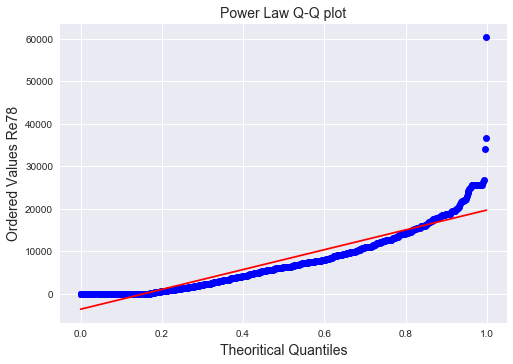

In [5]:
sns.distplot(df['re78'], fit=stats.expon,kde=False)
# sm.qqplot(data['re78'], line='45')
plt.title('Re78 distribution with EFrom this plots it is hard to discriminate the distribution because the QQ plots have many outliersxponential fit',fontsize=14)
plt.show()

sns.distplot(df['re78'], fit=stats.powerlaw,kde=False)
# sm.qqplot(data['re78'], line='45')
plt.title('Re78 distribution with Power Law fit',fontsize=14)
plt.show()


stats.probplot(df['re78'], dist=stats.expon, sparams=(2),plot=plt)
plt.ylabel('Ordered Values Re78', fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.title("Exponential Law Q-Q plot",fontsize=14)
plt.show()

stats.probplot(df['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Power Law Q-Q plot",fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Re78', fontsize=14)
plt.show()

From these plots, it is hard to distinguish the distribution because the QQ plots have many outliers. The first representations will focus on categorical covariates. 

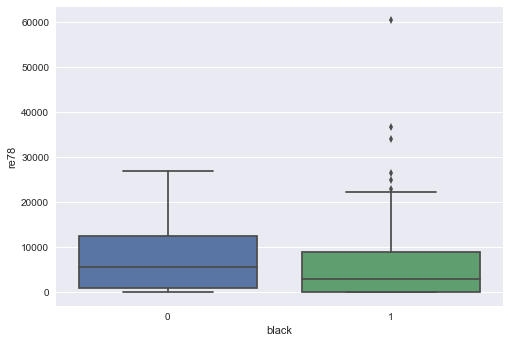

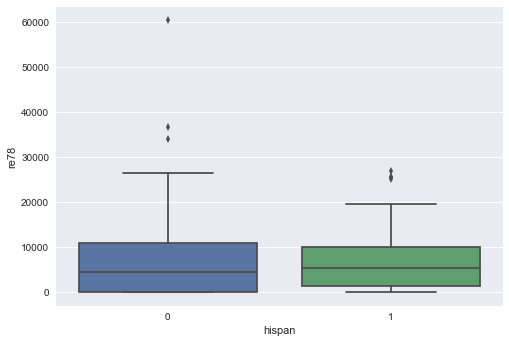

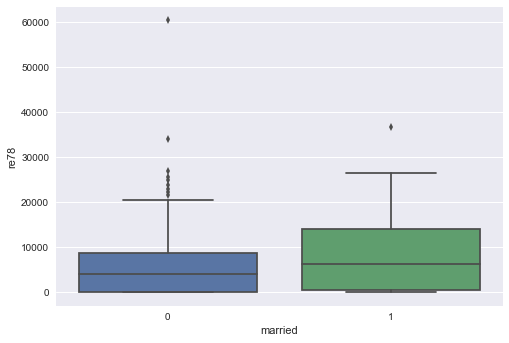

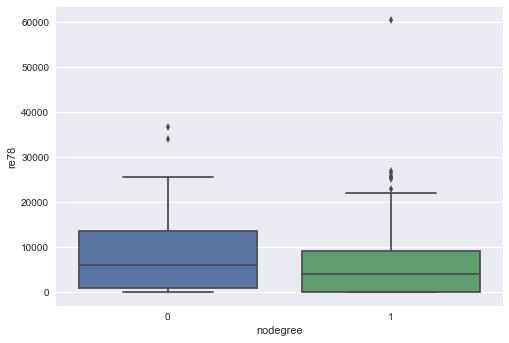

In [6]:
categorical = ['black','hispan','married','nodegree']
for i in categorical:
    sns.boxplot(x=i, y="re78", data=df)
    plt.show()

Then let's look at continous covariate values:

In [7]:
continous_features = ['age','educ','re74','re75']

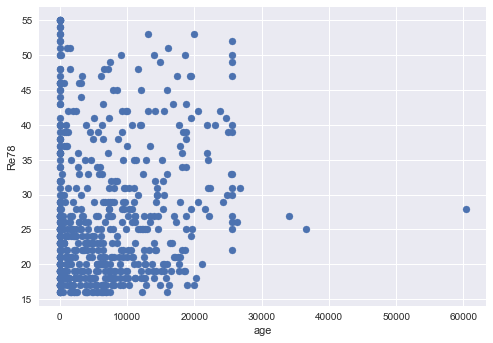

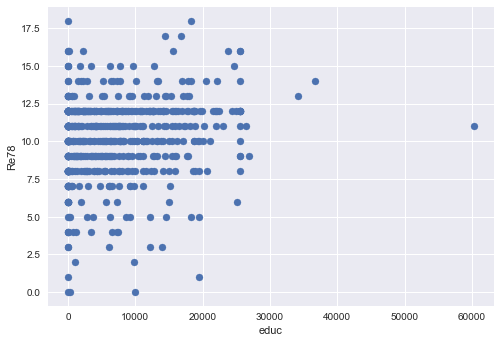

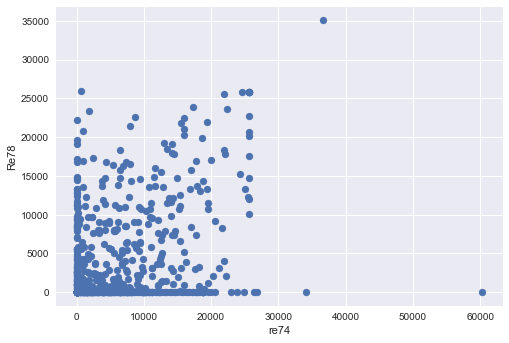

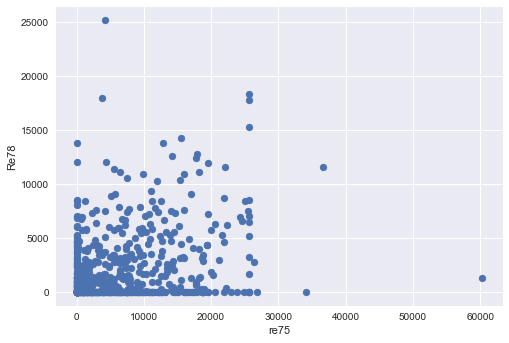

In [9]:
for ft in continous_features:
    plt.scatter(df['re78'], df[ft])
    #plt.title('Feature: %s (jittered)'%(ft))
    plt.xlabel(ft)
    plt.ylabel('Re78')
    plt.show()

Here no linear correlation is found between the continous covaraites and Re78. Regarding education we can try to split it in low and high education

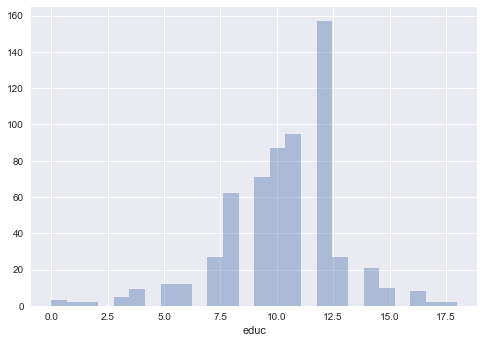

In [11]:
# education distribution
sns.distplot(df['educ'], kde=False)
plt.show()

We can choose a threshold of 12 years of study, which roughly corresponds to the end of high school (assumption)

In [12]:
df['educ_thres12'] = 1
df.loc[df['educ'] <12, 'educ_thres12'] = 0

# sns.boxplot(x=i, y#Add the new variable to our table
# plt.show()

We have seen that for the continous covariates no correlation as been seen
Here we try basic statistical analysis. Since the data distribution is not normal and the number of samples is not very big, we use a non parametric test

In [13]:
# add the new variable to our table
categorical = categorical + ['educ_thres12']

Let's look at the influence of the covariates and how they could bias our score

In [14]:
for i in categorical:
     print('covariate =',i,' ', stats.ranksums(df['re78'][df[i]==1], df['re78'][df[i]==0]))

covariate = black   RanksumsResult(statistic=-3.5868841633784352, pvalue=0.00033465289541746658)
covariate = hispan   RanksumsResult(statistic=0.90156565385238707, pvalue=0.36728764298738426)
covariate = married   RanksumsResult(statistic=3.2700394528267465, pvalue=0.0010753248556850177)
covariate = nodegree   RanksumsResult(statistic=-2.9165541847092897, pvalue=0.0035392124311496519)
covariate = educ_thres12   RanksumsResult(statistic=2.9165541847092897, pvalue=0.0035392124311496519)


In [16]:
# now we compare the outcome given the treatment: 
print('Effect of the treatment:', stats.ranksums(df['re78'][df['treat']==1], df['re78'][df['treat']==0]))

Effect of the treatment: RanksumsResult(statistic=-1.0697674002995952, pvalue=0.28472401948773163)


### Conclusion: 
At a significance level of 0.05, It seems that the African-American origin, the marriage status, and education degree (or abscence of it) have an influence on the salary of the participants. However the job training program (treat) has no significant effect!

### 2. A closer look at the data
#### You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

#### For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

#### What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

### 3. A propensity score model

#### Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores. Note: you do not need a train/test split here. Train and apply the model on the entire dataset. 

We want to the model with the whole training set to get logistic regression model with x=covariates and y= treatment  

In [17]:
covariates = df[['age','educ','black','hispan','married','nodegree','re74','re75']]
fn = linear_model.LogisticRegression()

# predict_proba returns the probability of the sample for each class in the model, where classes are ordered as they are in self.classes_.

logistic = fn.fit(covariates, df.treat.ravel()) 
propensity_score=fn.predict_proba(covariates)[:,1] 

In [18]:
# append the score to the table
df['Propensity_S'] = propensity_score
propensity_score[0:5]

array([ 0.44335042,  0.14465953,  0.72235463,  0.66415052,  0.69828561])

### 4. Balancing the dataset via matching

#### Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

#### Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

#### After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

#### Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

In [20]:
set1 = df['Propensity_S'][df['treat']==0] # control
set2 = df['Propensity_S'][df['treat']==1] # treat 

### 5. Balancing the groups further

### 6. A less naive analysis

## Question 2: Applied ML

### Part 1

### Part 2